In [ ]:
##### 1. Create time series images and extract time series at a specific point

In [2]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Successfully saved authorization token.


In [3]:
# Import the MODIS NDVI collection.
ndvi = ee.ImageCollection('MODIS/006/MOD13A1')
# Import the MODIS land surface temperature collection.
LSTemp = ee.ImageCollection('MODIS/006/MOD11A1')

In [4]:

# Read data between two dates
start_date = '2000-01-01'
# Final date of interest (exclusive).
end_date = '2022-12-31'
# Time series of Land surface temperature images
lst = LSTemp.select('LST_Day_1km', 'QC_Day').filterDate(start_date, end_date)
# Time series of NDVI images 
ndvi = ndvi.select('NDVI').filterDate(start_date, end_date)



In [5]:
##### Time series for a location
lat, lon = 48.48, 2.78
Point=ee.Geometry.Point([lon,lat])
# Get the data for the pixel intersecting the point
scale = 1000
lst_point = lst.getRegion(Point, scale).getInfo()
ndvi_point = ndvi.getRegion(Point, scale).getInfo()
# Preview the result.
lst_point[:5]
ndvi_point[:5]


[['id', 'longitude', 'latitude', 'time', 'NDVI'],
 ['2000_02_18', 2.7802858043499192, 48.47758430750998, 950832000000, 4720],
 ['2000_03_05', 2.7802858043499192, 48.47758430750998, 952214400000, 4657],
 ['2000_03_21', 2.7802858043499192, 48.47758430750998, 953596800000, 5185],
 ['2000_04_06', 2.7802858043499192, 48.47758430750998, 954979200000, 5523]]

In [6]:
import pandas as pd

def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', *list_of_bands]].dropna()

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime',  *list_of_bands]]

    return df

In [8]:
lst_df_point = ee_array_to_df(lst_point,['LST_Day_1km'])
def t_modis_to_celsius(t_modis):
    """Converts MODIS LST units to degrees Celsius."""
    t_celsius =  0.02*t_modis - 273.15
    return t_celsius
# Apply the function to get temperature in celsius.
lst_df_point['LST_Day_1km'] = lst_df_point['LST_Day_1km'].apply(t_modis_to_celsius)
lst_df_point.head()

,time,datetime,LST_Day_1km
3,951609600000,2000-02-27,12.47
7,951955200000,2000-03-02,8.17
10,952214400000,2000-03-05,6.67
11,952300800000,2000-03-06,11.13
12,952387200000,2000-03-07,7.95


In [9]:
ndvi_df_point = ee_array_to_df(ndvi_point,['NDVI'])
def NDVI_modis_rescaled(ndvi_modis):
    """Converts MODIS NDVI between -1 and 1"""
    ndvi_rescaled =  0.0001*ndvi_modis
    return ndvi_rescaled
# Apply the function to get temperature in celsius.
ndvi_df_point['NDVI'] = ndvi_df_point['NDVI'].apply(NDVI_modis_rescaled)
ndvi_df_point.head()

,time,datetime,NDVI
0,950832000000,2000-02-18,0.4720
1,952214400000,2000-03-05,0.4657
2,953596800000,2000-03-21,0.5185
3,954979200000,2000-04-06,0.5523
4,956361600000,2000-04-22,0.7865


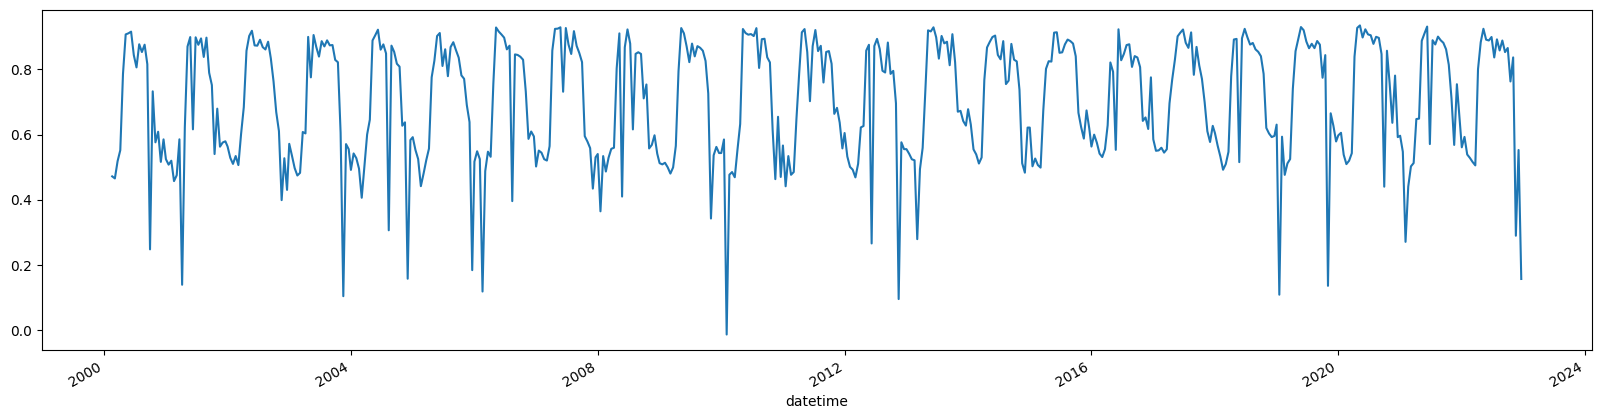

In [10]:
ndvi_df_point.set_index('datetime', inplace=True)
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5)) 
ndvi_df_point['NDVI'].plot()
plt.show()

In [28]:
import numpy as np
from scipy.optimize import curve_fit

# Define the harmonic function.
def harmonic(x, A, B, C, D):
    return A * np.sin(B * (x - np.radians(C))) + D

# Convert the DateTime index to numeric values for curve fitting.
xdata = np.arange(len(ndvi_df_point))

# Get the NDVI values.
ydata = ndvi_df_point['NDVI'].values

# Provide initial parameters for the curve fit.
guess = [0.1, 0.1, 0, 0.3]

# Fit the harmonic function to the data.
params, params_covariance = curve_fit(harmonic, xdata, ydata, p0=guess)

# Print the parameters.
print(params)

[ 1.54401892e-02  9.58741519e-02 -1.35165445e+03  7.00680627e-01]


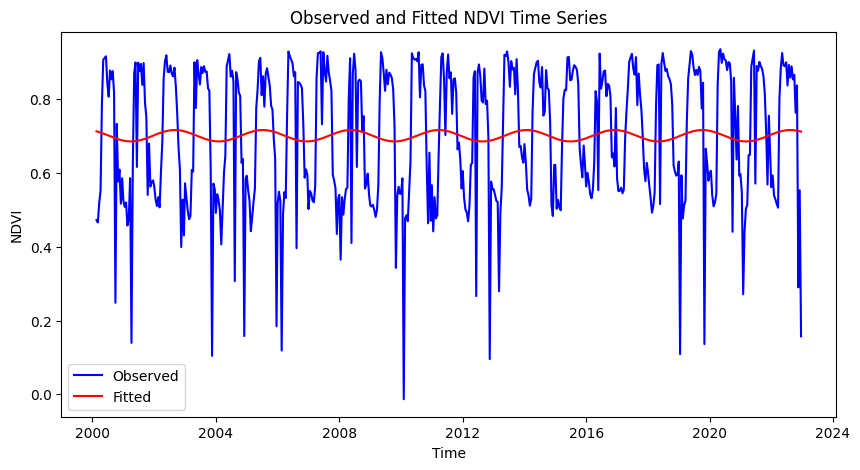

In [29]:
import matplotlib.pyplot as plt

# Plot the original data.
plt.figure(figsize=(10, 5))
plt.plot(ndvi_df_point.index, ydata, 'b-', label='Observed')

# Plot the fitted harmonic function.
plt.plot(ndvi_df_point.index, harmonic(xdata, *params), 'r-', label='Fitted')

plt.xlabel('Time')
plt.ylabel('NDVI')
plt.legend()
plt.title('Observed and Fitted NDVI Time Series')
plt.show()